In [1]:
import os
import math
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import signal
from scipy.io import wavfile
from collections import OrderedDict
from tqdm import tqdm

In [2]:
input_dir = "../data/full_recordings"
output_dir = "../data/full_recordings/jw_processed_audio"

input_files = [f for f in os.listdir(input_dir) if f.endswith(".wav")]

In [3]:
def process(fname, input_dir, output_dir, rate=12, dtype=np.int16, save=False):
    sr, data = wavfile.read(os.path.join(input_dir, fname))
    data = signal.decimate(data, rate)
    data = data.astype(float)
    data = data - data.min()
    data = (data / data.max()) - 0.5
    data = (data * np.iinfo(np.int16).max).astype(np.int16)
    sr = sr // rate
    if save:
        out_fname = "{}_processed.wav".format(os.path.splitext(fname)[0])
        wavfile.write(os.path.join(output_dir, out_fname), sr, data)
    return sr, data

In [4]:
for fname in tqdm(input_files):
    process(fname, input_dir, output_dir, save=True)

100%|██████████| 77/77 [22:53<00:00, 17.83s/it]


# Test

In [5]:
example_full = input_files[9]
example_processed = "{}_norm_8k-resample.wav".format(os.path.splitext(example_full)[0])
sr1, data1 = process(example_full, input_dir, output_dir)
data1 = data1.astype(float)
data1 = data1 - data1.min()
data1 = data1 / data1.max()
data1 = data1 - 0.5
sr2, data2 = wavfile.read(os.path.join("../data/full_recordings/processed_audio", example_processed))
data2 = data2.astype(float)
data2 = data2 - data2.min()
data2 = data2 / data2.max()
data2 = data2 - 0.5

In [6]:
def get_mel_spec(data, samplerate, n_fft=32768, hop_length=512, n_mels=512, fmax=1600, figsize=(15, 5),
                 plot=False):
    # Compute & Draw Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=data,
                                              sr=samplerate,
                                              n_fft=n_fft,
                                              hop_length=hop_length,
                                              n_mels=n_mels,
                                              fmax=fmax,
                                              center=True)
    S_dB = librosa.power_to_db(mel_spec, ref=np.max)
    if plot:
        plot_mel_spec(S_dB, samplerate, hop_length, fmax, figsize)
    return S_dB
    
def plot_mel_spec(spec, samplerate, hop_length, fmax, figsize):
    plt.figure(figsize=figsize)
    librosa.display.specshow(spec,
                             x_axis='time',
                             y_axis='mel',
                             sr=samplerate,
                             hop_length=hop_length,
                             fmax=fmax)
    
    # Decorate Plot
    plt.xlabel("Time (Seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Mel Spectrogram")
    plt.show()
    plt.close()

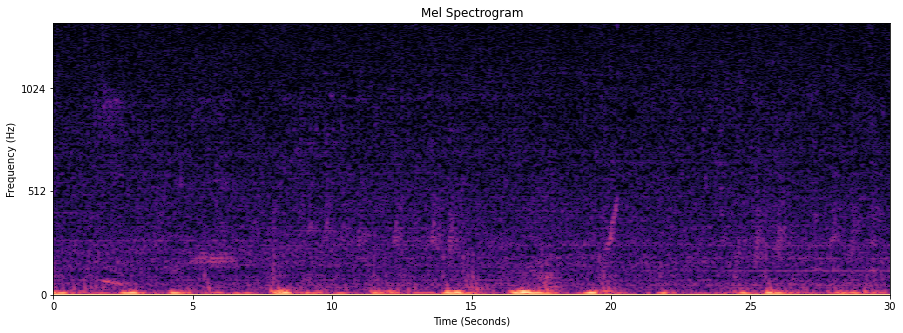

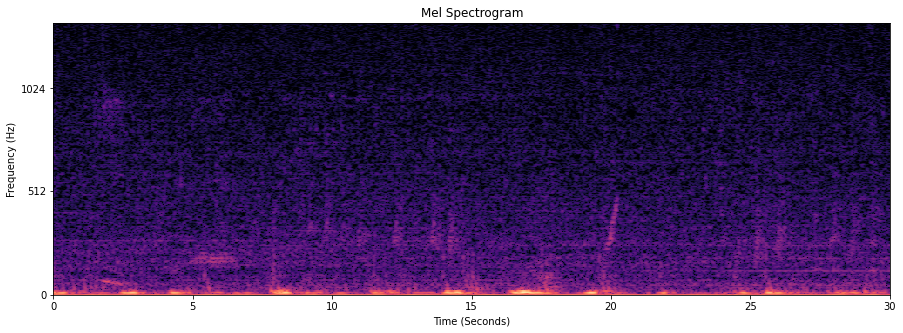

In [7]:
n_fft1 = sr1 // 4
hop_length1 = n_fft1 // 8

n_fft2 = sr2 // 4
hop_length2 = n_fft2 // 8

seconds_to_plot = 30

mel_spec1 = get_mel_spec(data1[:sr1*seconds_to_plot], sr1, n_fft=n_fft1, hop_length=hop_length1, n_mels=512,
                         fmax=1600, plot=True)
mel_spec2 = get_mel_spec(data2[:sr2*seconds_to_plot], sr2, n_fft=n_fft2, hop_length=hop_length2, n_mels=512,
                         fmax=1600, plot=True)

(512, 961) (512, 961)


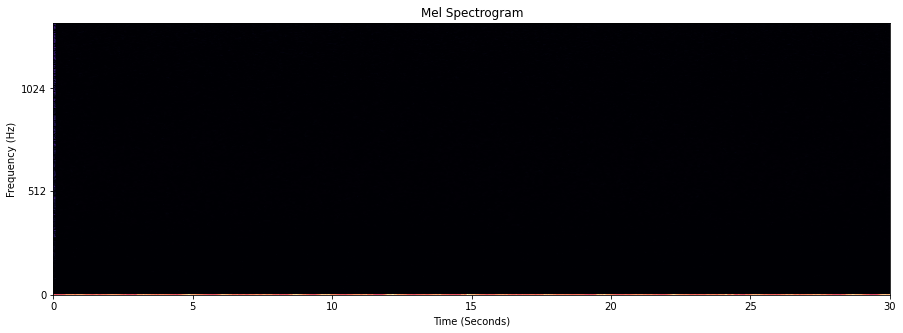

In [8]:
print(mel_spec1.shape, mel_spec2.shape)

mel_spec_diff = abs(mel_spec1 - mel_spec2)

plot_mel_spec(mel_spec_diff, 32, 1, 1600, (15, 5))